<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M0.532 · Pattern Recognition</p>
<p style="margin: 0; text-align:right;">Computational Engineering and Mathematics Master</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Computers, Multimedia and Telecommunications Department</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

In this notebook, we will see how to use another segmentation model which is also very popular, not only for instance segmentation but also for semantic segmentation: the [DeepLabV3 model](https://arxiv.org/abs/1706.05587). This is a model which is included in the torchvision library. This notebook is based on [this notebook](https://colab.research.google.com/github/tugstugi/dl-colab-notebooks/blob/master/notebooks/TorchvisionDeepLabV3.ipynb).





First of all, we import some libraries.

In [ ]:
import os
from os.path import exists, join, basename, splitext

import random
#import PIL
import torchvision
import cv2
import numpy as np
import torch
torch.set_grad_enabled(False)
  
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Then, we download the DeepLabV3 model from the segmentations models available in the torchvision library. We specify that we will use the model for inference and with a GPU (You will need to change the runtime type to GPU).

In [ ]:
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
model = model.eval().cuda()

We download the image that we will use for inference. We decide to use the same image as in the previous notebook (the one for Detectron2 and Mask R-CNN) to compare the results obtained with both models on the same image.

In [ ]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")

We convert the image to a Tensor and we pass it through the model to obtain the predicted segmentation.

In [ ]:
t = time.time()
#image = PIL.Image.open(image_file)
image_tensor = torchvision.transforms.functional.to_tensor(im).cuda()
output = model(image_tensor.unsqueeze(0))
print('executed in %.3fs' % (time.time() - t))

executed in 0.212s


We first transform the prediction outputs, which are Tensors, to NumPy arrays. For each pixel in the image, we get the category with the maximum confidence score. We convert the category index to a np.uint8 so that the we can use them as the keys of the label_to_color dictionary. Therefore, each pixel image will be represented with a colour associated to a given class category. Two different images are generated. The pred_label_img_color image has each pixel with the correponding colored category predicted. The overlayed_img image is a representation of the previous pred_label_img_color overlaying the original image with some transparency applied.

In [ ]:
outputs = output['out'].cpu().numpy() # (shape: (batch_size, num_classes, img_h, img_w))
pred_label_imgs = np.argmax(outputs, axis=1) # (shape: (batch_size, img_h, img_w))
pred_label_imgs = pred_label_imgs.astype(np.uint8)

label_names = ['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'] 
def label_img_to_color(img):
    label_to_color = {
        0: [128, 64,128], 1: [244, 35,232], 2: [ 70, 70, 70], 3: [102,102,156],
        4: [190,153,153], 5: [153,153,153], 6: [250,170, 30], 7: [220,220,  0],
        8: [107,142, 35], 9: [152,251,152], 10: [ 70,130,180], 11: [220, 20, 60],
        12: [255,  0,  0], 13: [  0,  0,142], 14: [  0,  0, 70], 15: [  0, 60,100],
        16: [  0, 80,100], 17: [  0,  0,230], 18: [119, 11, 32], 19: [81,  0, 81]
        }

    img_height, img_width = img.shape
    img_color = np.zeros((img_height, img_width, 3))
    for row in range(img_height):
        for col in range(img_width):
            label = img[row, col]
            img_color[row, col] = np.array(label_to_color[label])

    return img_color


i = 0
pred_label_img = pred_label_imgs[i] # (shape: (img_h, img_w))
img = image_tensor #imgs[i] # (shape: (3, img_h, img_w))

img = img.data.cpu().numpy()
img = np.transpose(img, (1, 2, 0)) # (shape: (img_h, img_w, 3))
img = img*np.array([0.229, 0.224, 0.225])
img = img + np.array([0.485, 0.456, 0.406])
img = img*255.0
img = img.astype(np.uint8)

pred_label_img_color = label_img_to_color(pred_label_img)
overlayed_img = 0.35*img + 0.65*pred_label_img_color
overlayed_img = overlayed_img.astype(np.uint8)

Here we show the pred_label_img_color image.

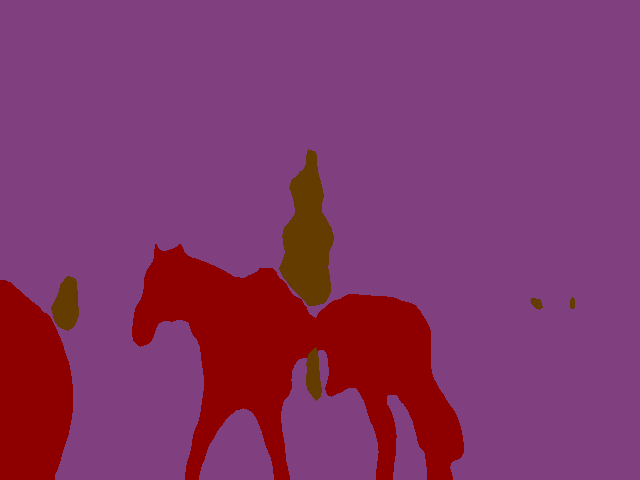

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(pred_label_img_color)

And here we show the overlayed_img.

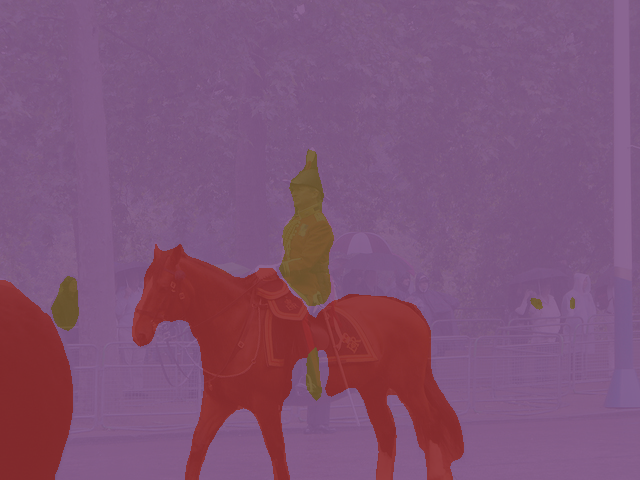

In [ ]:
cv2_imshow(overlayed_img)